# Evaluación de selección para el puesto: Prácticante Preprofesional de Ciencia de Datos
*El presente documento ha sido exportado en formato PDF desde Jupyter Notebook (localhost)*.

#### Planteamiento del caso práctico
Cierta compañía internacional de venta directa tiene un catálogo que tiene
21 días de vida, los primeros tres días se reciben alrededor del 30% (en
promedio) de los pedidos totales que corresponden a los 10 grupos de venta.

##### ¿Qué se requiere predecir?
Con los pedidos registrados en los primeros tres días por los 10 grupos de venta, se busca **pronosticar los pedidos totales al cierre de los
21 días**, es decir al cierre de cada campaña.

##### Pasos para encontrar la mejor solución
Se entiende por **mejor solución** aquel modelo predictivo de Machine Learning que mejor se ajuste a los datos brindados y a las características extraidas a partir de hacer un análisis estadístico.

1. Configurar el entorno de trabajo
2. Cargar los datos (del archivo de Excel)
3. Análisis
    1. Análisis previo
    2. Limpieza
    3. Ingeniería de características
    4. Filtrado
4. Entrenamiento
5. Métricas

**Repositorio de la solución** : *https://github.com/felipeturing/azzorti*

###  1. Configurar el entorno de trabajo

Configurar el entorno virtual (Python3 venv), instalar las librerías necesarias para luego importarlas en Python3, entre las más importantes y las más usadas son **Pandas**, **Numpy**, **Matplotlib** y **Scikit-learn**.

A continuación una lista de instrucciones que me va permitir configurar mi entorno virtual de trabajo en Python3 y el repositorio remoto en GitHub.

In [150]:
!cd ~/workspace/azzorti
!git clone github https://{user}:{token}github.com/felipeturing/azzorti .
!python3 -m venv azzorti-env
!source azzorti-env/bin/activate
!pip3 install numpy openpyxl pandas matplotlib seaborn scikit-learn
!echo "Lista de módulos de Python3 usando PIP3 en el venv azzorti-env"
!pip3 list

Lista de módulos de Python3 usando PIP3 en el venv azzorti-env
Package         Version
--------------- -------
cycler          0.11.0 
et-xmlfile      1.1.0  
fonttools       4.34.4 
joblib          1.1.0  
kiwisolver      1.4.3  
matplotlib      3.5.2  
numpy           1.23.1 
openpyxl        3.0.10 
packaging       21.3   
pandas          1.4.3  
Pillow          9.2.0  
pip             20.0.2 
pkg-resources   0.0.0  
pyparsing       3.0.9  
python-dateutil 2.8.2  
pytz            2022.1 
scikit-learn    1.1.1  
scipy           1.8.1  
seaborn         0.11.2 
setuptools      44.0.0 
six             1.16.0 
threadpoolctl   3.1.0  
xlrd            2.0.1  


Ahora pasamos a importar todas las librerias necesarias para el desarrollo de la solución.

In [151]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split # Dividir entrenamiento y prueba
from sklearn.linear_model import LinearRegression # Regresión lineal
from sklearn.ensemble import RandomForestRegressor # Árboles aleatorios
from sklearn.ensemble import GradientBoostingRegressor # GBoosting
from sklearn.cluster import KMeans # Clustering
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score # Métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Escalar

%matplotlib inline

###  2. Cargar los datos

Se usa la librería Pandas para obtener un objeto de tipo pandas.DataFrame del archivo excel de datos llamado "*Datos_201901_202009.xlsx*". 
Además se describe los metadatos del DataFrame y se muestra las tres primeras campañas del 2019 y 2020.

In [152]:
%%time
datos = pd.read_excel("datos/Datos_201901_202009.xlsx", index_col=None, engine="openpyxl") # pandas.DataFrame
#print("Metadatos del DataFrame \n" + datos.info().__str__())
datos.info()

# Obtener los nombres de las columnas de los grupos
grupos = datos.columns[1:-1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   CAMPAÑA          27 non-null     int64
 1   GRUPO_1          27 non-null     int64
 2   GRUPO_2          27 non-null     int64
 3   GRUPO_3          27 non-null     int64
 4   GRUPO_4          27 non-null     int64
 5   GRUPO_5          27 non-null     int64
 6   GRUPO_6          27 non-null     int64
 7   GRUPO_7          27 non-null     int64
 8   GRUPO_8          27 non-null     int64
 9   GRUPO_9          27 non-null     int64
 10  GRUPO_10         27 non-null     int64
 11  PEDIDOS_TOTALES  27 non-null     int64
dtypes: int64(12)
memory usage: 2.7 KB
CPU times: user 30.5 ms, sys: 3.71 ms, total: 34.3 ms
Wall time: 52.6 ms


Tal cual se describe en las anotaciones entregadas, se muestra todos las variables o columnas
1. **CAMPAÑA**: Indicador de qué campaña se trata. Los primeros cuatro dígitos hacen referencia al año y los siguientes dos dígitos a la campaña. En el año se tienen 18 campañas y cada campaña dura 21 días.
2. **GRUPO_N**: Número de pedidos del grupo N durante los primeros 3 días.
3. **PEDIDOS_TOTALES**: Pedidos totales al cierre de la campaña que dura 21 días, considerada la variable dependiente a predecir.

Todos los tipos de datos que considero Pandas son **int64** y no hay valores nulos desde una primera observación en todos los 27 registros.

A continuación mostramos cierto contenido del DataFrame, las tres primeras campañas del 2019 y 2020.

In [153]:
pd.concat([datos[ datos['CAMPAÑA'] < 202000 ].head(3), 
           datos[ datos.CAMPAÑA > 202000 ].head(3)])

,CAMPAÑA,GRUPO_1,GRUPO_2,GRUPO_3,GRUPO_4,GRUPO_5,GRUPO_6,GRUPO_7,GRUPO_8,GRUPO_9,GRUPO_10,PEDIDOS_TOTALES
0,201901,6492,6062,2961,1652,1190,89,31,410,15,43,54113
1,201902,4757,3618,2089,855,399,54,13,19,9,20,43091
2,201903,5047,3031,1018,309,157,63,12,7,8,10,50112
18,202001,6159,5611,3427,1348,210,151,39,15,23,11,48886
19,202002,4786,4207,1534,549,148,126,31,9,10,8,47766
20,202003,5935,4902,2390,481,133,146,31,19,8,16,51204


###  2. Análisis

En esta sección o paso de la solución se encuentra la mayor complejidad del problema, debido a que se requiere ser perspicaz y detallista con el estudio de los datos para poder encontrar relaciones y caracteríticas que permitan que los modelos de Machine Learning aplicados sean más robustos.

#### 2.A Análisis previo
Primero vamos a describir estadísticamente las variables definidas por los grupos y los pedidos_totales.

In [154]:
datos[datos.columns[1:]].describe()

,GRUPO_1,GRUPO_2,GRUPO_3,GRUPO_4,GRUPO_5,GRUPO_6,GRUPO_7,GRUPO_8,GRUPO_9,GRUPO_10,PEDIDOS_TOTALES
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,6423.407407,5044.185185,2922.037037,939.037037,416.074074,232.666667,33.814815,47.370370,35.444444,22.074074,55574.814815
std,1075.220666,998.678051,1069.612528,577.807360,412.075136,255.798148,31.527811,84.199008,87.200623,21.845482,6201.122641
min,4328.000000,3031.000000,1018.000000,100.000000,37.000000,36.000000,3.000000,1.000000,2.000000,6.000000,43091.000000
25%,5836.500000,4436.000000,2072.500000,533.500000,152.500000,81.000000,17.500000,10.000000,8.500000,11.000000,50666.000000
50%,6502.000000,5200.000000,3112.000000,759.000000,219.000000,136.000000,27.000000,19.000000,15.000000,15.000000,56072.000000
75%,7185.000000,5695.000000,3750.500000,1359.000000,517.500000,284.500000,39.500000,37.500000,23.000000,23.500000,59168.500000
max,8783.000000,6990.000000,4894.000000,2013.000000,1529.000000,1110.000000,172.000000,410.000000,458.000000,105.000000,66863.000000


Se observa que generalmente la media va disminuyendo en los grupos desde el GRUPO_1 hasta el GRUPO_10. Además los tres primeros grupos son los que aportan más pedidos a los PEDIDOS_TOTALES, seguramente por influencia de otra variables como la región, zona, localidad, estrategias más efectivas de ventas por catálogo, Por influencia personal, entre otras características que se escapan de este estudio.

Además la mediana (el percentil 50%) se aproxima en muchos grupos a la media, esto puede dar a entender que se puede aproximar a una distribución normal, debemos comprobarlo visualmente con las gráficas de distribuciones de las variables.

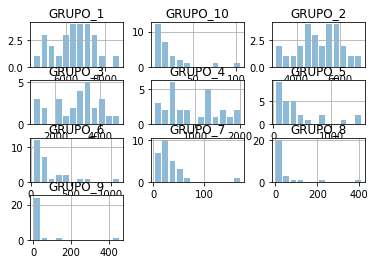

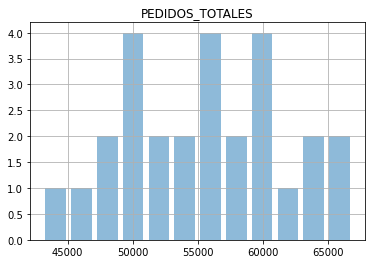

In [215]:
datos[grupos].hist(bins=12, alpha=0.5, rwidth=0.8)
datos[pedidos_totales].hist(bins=12, alpha=0.5, rwidth=0.8)
plt.show()

Hay algunos grupos que se aproximan a la distribución normal, se considerará para usar el StandardScaler antes
del entrenamiento, por otro lado también probar con el MinMaxScaler para ver si reduce la incertidumbre.

Ahora vamos a ver si existe alguna correlación entre las variables grupos usando el muy conocido Heatmap

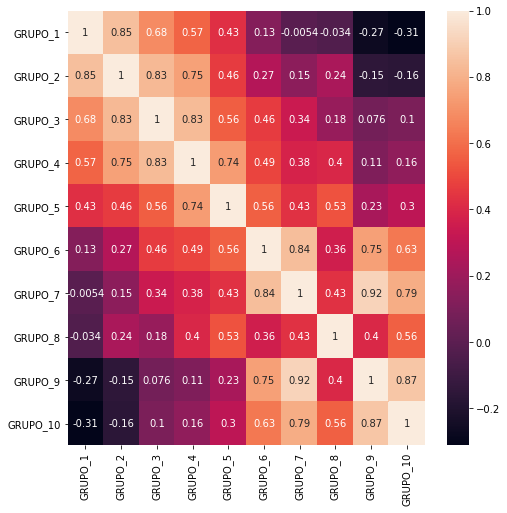

In [228]:
_, ejes = plt.subplots(figsize = (8, 8))
sns.heatmap(datos[grupos].corr(), annot=True, ax=ejes)
plt.show()

Se observa que en el primer cuadrante hay una intención de correlación directa, es decir los GRUPO_1, GRUPO_2, GRUPO_3 Y GRUPO_4 están caracterizados por "detalles" similares, ya que todos siguen el fujo de correlación. Asímismo con el cuarto cuadrante entre los demás grupos, excepto el GRUPO_5. Son detalles a considerar a los hora de definir las características (en la Ingeniería de características)

#### 2.B Limpieza
Primero vamos a describir estadísticamente las variables definidas por los grupos y los pedidos_totales. 

In [ ]:
#datos.head(5) # Primeras 5 campañas del 2019
#datos.columns # Listar las columnas
#datos.info() # Lista de metadatos del DataFrame
#datos["PEDIDOS_TOTALES"].describe() # Estadística descriptiva básica de la columna PEDIDOS_TOTALES
#datos[ datos.CAMPAÑA < 202000 ].head(5)# Primeras 5 campañas del 2020

## Gráfico para relacionar variables
#datos.plot(kind='scatter',x='GRUPO_1',y='GRUPO_2',color='red')
#plt.show()

#fig, ax = plt.subplots(figsize = (15, 10))
#sns.heatmap(datos.corr(), annot=True, ax=ax)
#plt.show()

#df = pd.DataFrame(
#    np.random.randint(1, 7, 6000),
#    columns = ['one'])
#df['two'] = df['one'] + np.random.randint(1, 7, 6000)

In [ ]:
#datos.plot(kind='bar',x='CAMPAÑA', y='CAMBIO_PORCENTUAL_GRUPO_1',color='red')


#datos["AÑO_CAMPAÑA"].value_counts().plot(kind="bar", figsize=(5, 4))
#plt.title("Cambios porcentuales entre campañas")
#plt.show()

In [676]:
%%time
suma_grupos = datos['GRUPO_1'] + datos['GRUPO_2'] + datos['GRUPO_3'] + datos['GRUPO_4'] + datos['GRUPO_5'] + datos['GRUPO_6'] + datos['GRUPO_7'] + datos['GRUPO_8'] + datos['GRUPO_9'] + datos['GRUPO_10']
datos['PROMEDIO_GRUPOS_LOG'] = np.log( suma_grupos / 10 )

datos['AÑO_CAMPAÑA'] = datos['CAMPAÑA'] // 100
datos['TERCIO_AÑO_CAMPAÑA'] = (datos['CAMPAÑA'] % 100) // 3 # Falta optimizar esta característica

datos['GRUPO_1_LOG'] = np.log(datos['GRUPO_1'])
datos['GRUPO_2_LOG'] = np.log(datos['GRUPO_2'])
datos['GRUPO_3_LOG'] = np.log(datos['GRUPO_3'])
datos['GRUPO_4_LOG'] = np.log(datos['GRUPO_4'])
datos['GRUPO_5_LOG'] = np.log(datos['GRUPO_5'])
datos['GRUPO_6_LOG'] = np.log(datos['GRUPO_6'])
datos['GRUPO_7_LOG'] = np.log(datos['GRUPO_7'])
datos['GRUPO_8_LOG'] = np.log(datos['GRUPO_8'])
datos['GRUPO_9_LOG'] = np.log(datos['GRUPO_9'])
datos['GRUPO_10_LOG'] = np.log(datos['GRUPO_10'])
datos['PEDIDOS_TOTALES_LOG'] = np.log(datos['PEDIDOS_TOTALES'])

datos['CAMBIO_PORCENTUAL_GRUPO_1'] = (datos['GRUPO_1'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_2'] = (datos['GRUPO_2'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_3'] = (datos['GRUPO_3'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_4'] = (datos['GRUPO_4'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_5'] = (datos['GRUPO_5'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_6'] = (datos['GRUPO_6'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_7'] = (datos['GRUPO_7'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_8'] = (datos['GRUPO_8'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_9'] = (datos['GRUPO_9'].pct_change(periods=1)).fillna(0)
datos['CAMBIO_PORCENTUAL_GRUPO_10'] = (datos['GRUPO_10'].pct_change()).fillna(0)

#datos = datos.drop(columns=['GRUPO_1', 'GRUPO_2', 'GRUPO_3', 'GRUPO_4', 'GRUPO_5', 'GRUPO_6',
#                            'GRUPO_7', 'GRUPO_8', 'GRUPO_9', 'GRUPO_10', 'CAMPAÑA', 'PEDIDOS_TOTALES'])
#datos.drop(columns=['GRUPO_1', 'GRUPO_2', 'GRUPO_3', 'GRUPO_4', 'GRUPO_5', 'GRUPO_6',
#                            'GRUPO_7', 'GRUPO_8', 'GRUPO_9', 'GRUPO_10', 'CAMPAÑA', 'PEDIDOS_TOTALES'], inplace=True)

#escalador_estandarizado = StandardScaler()
#datos = pd.DataFrame(escalador_estandarizado.fit_transform(datos)) # Escalado
#datos.head(5)
#ax = datos['GRUPO_1_LOG'].plot.hist(bins=12, alpha=0.5)
#datos.columns

CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 20.3 ms


In [667]:
#datos.plot(kind='scatter',x='SUMA_GRUPOS',y='PEDIDOS_TOTALES',color='red')

### Modelos de predicción

Se va modelar el problema usando 
    Linear Regresion
    -
    -
    -
   
La variables predictoras se analizaran de acuerdo al proceso de Ingeniería de Característica realizado previamente.

In [686]:
predictores = ['GRUPO_1_LOG', 'GRUPO_2_LOG', 'GRUPO_3_LOG', 'GRUPO_4_LOG', 'GRUPO_5_LOG', 'GRUPO_6_LOG',
               'GRUPO_7_LOG', 'GRUPO_8_LOG', 'GRUPO_9_LOG', 'GRUPO_10_LOG', 'TERCIO_AÑO_CAMPAÑA',
               'PROMEDIO_GRUPOS_LOG', 'CAMBIO_PORCENTUAL_GRUPO_1', 'CAMBIO_PORCENTUAL_GRUPO_1',
               'CAMBIO_PORCENTUAL_GRUPO_1', 'CAMBIO_PORCENTUAL_GRUPO_2', 'CAMBIO_PORCENTUAL_GRUPO_3',
               'CAMBIO_PORCENTUAL_GRUPO_4', 'CAMBIO_PORCENTUAL_GRUPO_5', 'CAMBIO_PORCENTUAL_GRUPO_6',
               'CAMBIO_PORCENTUAL_GRUPO_7', 'CAMBIO_PORCENTUAL_GRUPO_8', 'CAMBIO_PORCENTUAL_GRUPO_9',
               'CAMBIO_PORCENTUAL_GRUPO_10']

prediccion = 'PEDIDOS_TOTALES_LOG'

X = datos[predictores]
y = datos[prediccion]

#ESTANDARIZANDO
#scaler = MinMaxScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [687]:
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split( X, y, 
                                                                        train_size   = 0.8,
                                                                        random_state = 1234,
                                                                        shuffle      = True)

modelo_linear_regression = LinearRegression()
modelo_random_forest_regressor = RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=50,n_jobs=1)
modelo_gradient_boosting_regressor = GradientBoostingRegressor(n_estimators=60, learning_rate=0.5, max_depth=2, random_state=0)

modelo_linear_regression.fit(X_entrenamiento, y_entrenamiento)
modelo_random_forest_regressor.fit(X_entrenamiento, y_entrenamiento)
modelo_gradient_boosting_regressor.fit(X_entrenamiento, y_entrenamiento)

y_predict_linear_regression = modelo_linear_regression.predict(X_prueba)
y_predict_random_forest_regressor = modelo_random_forest_regressor.predict(X_prueba)
y_predict_gradient_boosting_regressor = modelo_gradient_boosting_regressor.predict(X_prueba)
y_predict_linear_regression

array([10.71274406, 10.96247113, 10.82521084, 10.91526498, 10.60005471,
       10.96643676])

In [4]:
def metricas(y_test, y_pred):
    r2score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("MSE", mse)
    print("RMSE", rmse)
    print("RMSE %", rmse * 100)
    #print("R2", r2score)
    #print("R2 %", r2score * 100)

In [688]:
metricas(y_prueba, y_predict_linear_regression)

MSE 0.03178465813037365
RMSE 0.1782825233453174
RMSE % 17.82825233453174


In [689]:
metricas(y_prueba, y_predict_random_forest_regressor)

MSE 0.00956724275714423
RMSE 0.09781228326311696
RMSE % 9.781228326311696


In [690]:
metricas(y_prueba, y_predict_gradient_boosting_regressor)

MSE 0.010959876807587672
RMSE 0.10468943025725029
RMSE % 10.468943025725029


In [521]:
# example of a normalization
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
# define data
data = asarray([[100, 0.001],
                [8, 0.05],
                [50, 0.005],
                [88, 0.07],
                [4, 0.1]])
print(data)
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(data)
print(scaled)

[[1.0e+02 1.0e-03]
 [8.0e+00 5.0e-02]
 [5.0e+01 5.0e-03]
 [8.8e+01 7.0e-02]
 [4.0e+00 1.0e-01]]
[[1.         0.        ]
 [0.04166667 0.49494949]
 [0.47916667 0.04040404]
 [0.875      0.6969697 ]
 [0.         1.        ]]
